In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Read the features dataset
from google.colab import drive
drive.mount('/content/drive')

dataset = pd.read_csv('/content/drive/My Drive/datasets/with-new-features.csv')
dataset

Mounted at /content/drive


,Id,ActivityMinute,Calories,Steps,Heartrate,is_morning,is_daytime,is_evening,is_sleep
0,2022484408,2016-04-12 07:21:00,3.32064,17,97.0,1,0,0,0
1,2022484408,2016-04-12 07:23:00,1.34901,0,60.0,1,0,0,0
2,2022484408,2016-04-12 07:24:00,1.03770,0,58.0,1,0,0,0
3,2022484408,2016-04-12 07:26:00,2.49048,7,53.0,1,0,0,0
4,2022484408,2016-04-12 07:27:00,1.03770,0,53.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
200068,8877689391,2016-05-12 12:23:00,8.24364,97,100.0,0,1,0,0
200069,8877689391,2016-05-12 12:24:00,8.24364,101,97.0,0,1,0,0
200070,8877689391,2016-05-12 12:25:00,7.75872,101,93.0,0,1,0,0
200071,8877689391,2016-05-12 13:54:00,1.33353,0,63.0,0,1,0,0


In [3]:
# dataset['ActivityMinute'] = pd.to_datetime(dataset['ActivityMinute'])

In [4]:
#Splitting the test day
df_test = dataset.loc[(dataset.ActivityMinute > '2016-04-21 00:00:00') & (dataset.ActivityMinute <= '2016-04-21 23:59:59')]
df = dataset.loc[(dataset.ActivityMinute < '2016-04-21 00:00:00') | (dataset.ActivityMinute > '2016-04-21 23:59:59')]

In [5]:
df = df.drop(['Id','ActivityMinute'], axis=1)
df_test = df_test.drop(['Id','ActivityMinute'], axis=1)

In [6]:
# Scale the data
scaler = MinMaxScaler()
scaler = scaler.fit(df)
scale_train = pd.DataFrame(scaler.transform(df))
scale_test = pd.DataFrame(scaler.transform(df_test))

In [7]:
# reshape to [samples, time_steps, n_features]
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_train, y_train = create_dataset(scale_train, scale_train, time_steps)
X_test, y_test = create_dataset(scale_test, scale_test, time_steps)

print(X_train.shape, y_train.shape)

(192839, 30, 7) (192839, 7)


In [8]:
#model building
import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, name='encoder_1'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(128, return_sequences=True, name='encoder_2'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(64, return_sequences=False, name='encoder_3'))
model.add(keras.layers.RepeatVector(n=X_train.shape[1], name='encoder_decoder'))
model.add(keras.layers.LSTM(64, return_sequences=True, name='decoder_1'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(128, return_sequences=True, name='decoder_2'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(256, return_sequences=True, name='decoder_3'))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 30, 256)           270336    
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 encoder_2 (LSTM)            (None, 30, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 encoder_3 (LSTM)            (None, 64)                49408     
                                                                 
 encoder_decoder (RepeatVect  (None, 30, 64)           0         
 or)                                                             
                                                        

Epoch 1/50
339/339 [==============================] - 32s 55ms/step - loss: 0.0575 - val_loss: 0.0625
Epoch 2/50
339/339 [==============================] - 17s 50ms/step - loss: 0.0391 - val_loss: 0.0526
Epoch 3/50
339/339 [==============================] - 17s 50ms/step - loss: 0.0328 - val_loss: 0.0465
Epoch 4/50
339/339 [==============================] - 17s 50ms/step - loss: 0.0297 - val_loss: 0.0422
Epoch 5/50
339/339 [==============================] - 17s 49ms/step - loss: 0.0279 - val_loss: 0.0422
Epoch 6/50
339/339 [==============================] - 17s 49ms/step - loss: 0.0276 - val_loss: 0.0401
Epoch 7/50
339/339 [==============================] - 17s 50ms/step - loss: 0.0269 - val_loss: 0.0383
Epoch 8/50
339/339 [==============================] - 17s 50ms/step - loss: 0.0266 - val_loss: 0.0379
Epoch 9/50
339/339 [==============================] - 17s 50ms/step - loss: 0.0265 - val_loss: 0.0364
Epoch 10/50
339/339 [==============================] - 17s 50ms/step - loss: 0.026

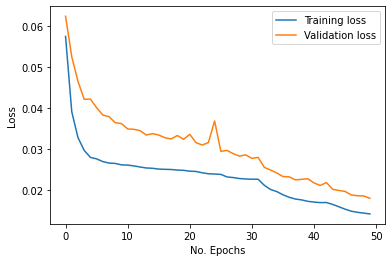

In [9]:
#fitting on training data
history = model.fit(X_train, X_train, epochs=50, batch_size=512,
                    validation_split=0.1,verbose=1,shuffle=False)
#plotting loss
fig=plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('No. Epochs')
plt.legend()
plt.show()

In [10]:
# predicting on test data

X_pred = model.predict(X_train)

6027/6027 [==============================] - 49s 8ms/step


In [12]:
X_pred_2d = pd.DataFrame(X_pred[:,0,:]).astype(float)
X_pred_2d.columns = ['Calories Pred', 'Steps Pred', 'Heartrate Pred', 'Morning Pred', 'Day Pred', 'Evening Pred', 'Sleep Pred']

In [13]:
X_train_2d = pd.DataFrame(X_train[:,0,:]).astype(float)
X_train_2d.columns = ['Calories Test', 'Steps Test', 'Heartrate Test', 'Morning Test', 'Day Test', 'Evening Test', 'Sleep Test']

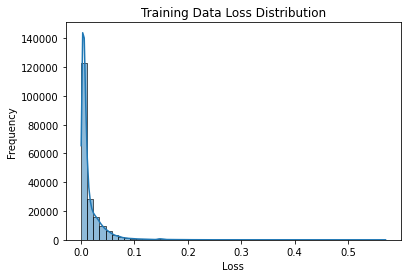

In [14]:
# calculate error
predictions = pd.concat([X_pred_2d['Calories Pred'], X_pred_2d['Steps Pred'], X_pred_2d['Heartrate Pred'], X_pred_2d['Morning Pred'], X_pred_2d['Day Pred'], X_pred_2d['Evening Pred'], X_pred_2d['Sleep Pred']], axis = 1)
train_inputs = pd.concat([X_train_2d['Calories Test'], X_train_2d['Steps Test'], X_train_2d['Heartrate Test'], X_train_2d['Morning Test'], X_train_2d['Day Test'], X_train_2d['Evening Test'], X_train_2d['Sleep Test']], axis = 1)

anomaly = pd.DataFrame(np.abs(predictions.values - train_inputs.values))
anomaly = anomaly.mean(axis=1)

ax = sns.histplot(anomaly, bins=50, kde = True)
ax.set_title('Training Data Loss Distribution')
ax.set_xlabel('Loss')
ax.set_ylabel('Frequency')
fig = ax.get_figure()

In [15]:
thres = round(np.quantile(anomaly, 0.99),3)
print('99th percentile loss value from training: ' + str(thres))
# 99th percentile loss value from training: 0.177

99th percentile loss value from training: 0.129


In [22]:
#Predicting
X_pred = model.predict(X_test)
X_pred = pd.DataFrame(X_pred[:,0,:]).astype(float)
X_pred.columns = ['Calories Pred', 'Steps Pred', 'Heartrate Pred', 'Morning Pred', 'Day Pred', 'Evening Pred', 'Sleep Pred']
X_test_data = pd.DataFrame(X_test[:,0,:]).astype(float)
X_test_data.columns = ['Calories Test', 'Steps Test', 'Heartrate Test', 'Morning Test', 'Day Test', 'Evening Test', 'Sleep Test']

225/225 [==============================] - 2s 8ms/step


In [23]:
difference = pd.DataFrame(np.abs(X_pred.values - X_test_data.values))
difference['mae loss'] = difference.mean(axis=1)
difference['threshold'] = thres
difference['anomaly'] = difference['mae loss'] > difference['threshold']
difference['index'] = difference.index
X_pred['index'] = X_pred.index
X_test_data['index'] = X_test_data.index
X_test_data = X_test_data.join(difference['anomaly'])

In [24]:
X_test_data_original = pd.DataFrame(scaler.inverse_transform(X_test_data[['Calories Test', 'Steps Test', 'Heartrate Test', 'Morning Test', 'Day Test', 'Evening Test', 'Sleep Test']]))
X_test_data = pd.concat([X_test_data, X_test_data_original], axis = 1)
X_test_data.columns = ['Calories Test', 'Steps Test', 'Heartrate Test', 'Morning Test', 'Day Test', 'Evening Test', 'Sleep Test', 'Index', 'Anomaly', 'Calories', 'Steps', 'Heartrate', 'is_morning',	'is_daytime',	'is_evening','is_sleep']

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


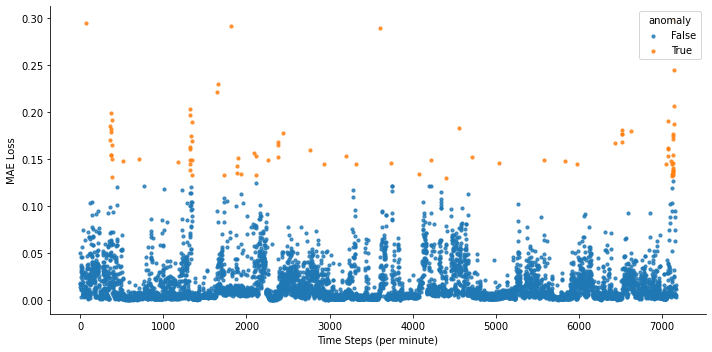

In [25]:
plt = sns.lmplot(x='index', y='mae loss', data=difference, 
           fit_reg=False, hue='anomaly', scatter_kws={"s": 10}, legend=True, legend_out=False, height=5, aspect=2)
plt.set(xlabel='Time Steps (per minute)', ylabel='MAE Loss')

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


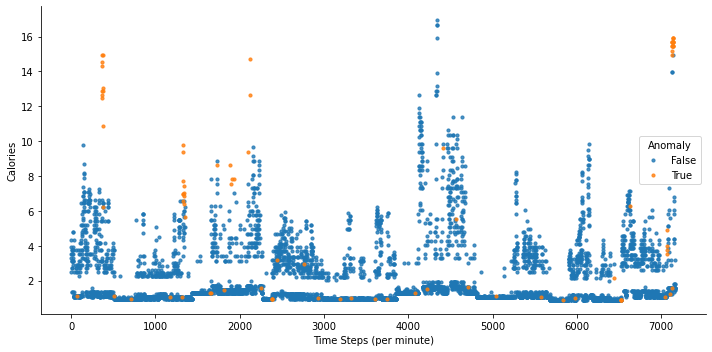

In [26]:
plt = sns.lmplot(x ='Index', y='Calories', scatter_kws={"s": 10}, data=X_test_data, 
           fit_reg=False, hue='Anomaly', legend=True, legend_out=False, height=5, aspect=2)
plt.set(xlabel='Time Steps (per minute)', ylabel='Calories')

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


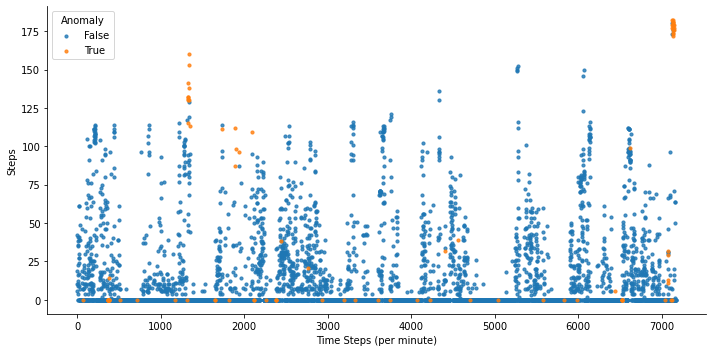

In [27]:
plt = sns.lmplot(x ='Index', y='Steps', scatter_kws={"s": 10}, data=X_test_data, 
           fit_reg=False, hue='Anomaly', legend=True, legend_out=False, height=5, aspect=2)
plt.set(xlabel='Time Steps (per minute)', ylabel='Steps')

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


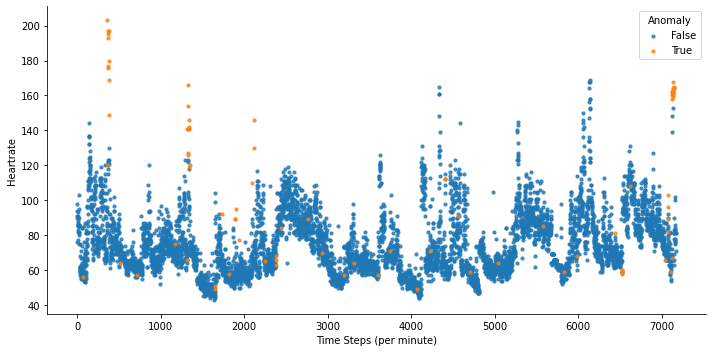

In [28]:
plt = sns.lmplot(x ='Index', y='Heartrate', scatter_kws={"s": 10}, data=X_test_data, 
           fit_reg=False, hue='Anomaly', legend=True, legend_out=False, height=5, aspect=2)
plt.set(xlabel='Time Steps (per minute)', ylabel='Heartrate')